In [1]:
!pip install pycuda

     |████████████████████████████████| 1.7 MB 5.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=627558 sha256=f9912f60edb4c96e6d2d81d43f58f51b32840e7ae021d68a03281d51f144c7a2
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2021.2.8-py2.py3-none-any.whl size=60725 sha256=8d91872674276042c625b4ec51f82a15f74c661aef2bf845130d77f8bb68bbae
  Stored in directory: /root/.cache/pip/wheels/bd/2d/ef/0127a17bafa44971f11d05d0e38d7947144cf9e33313bf12a7
Successfully built pycuda pytools


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: The CUDA compiler succeeded, but said the following:
nvcc warning : The 'compute_35', 'compute_37', 'compute_50', 'sm_35', 'sm_37' and 'sm_50' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).

/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mod']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Populating the interactive namespace from numpy and matplotlib


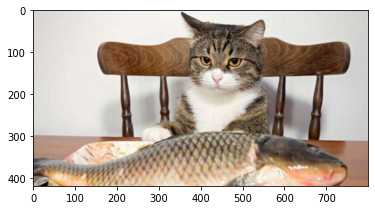

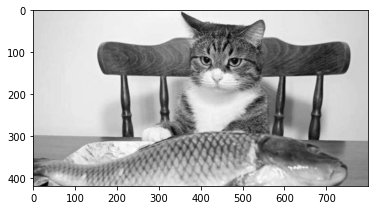

In [32]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np
import sys
from PIL import Image

image = Image.open("image.jpg")


h_imagePixel = np.array(image)
width, height = image.size
totalPixel = width*height

h_imagePixel = h_imagePixel.astype(np.uint8)
d_imagePixel = cuda.mem_alloc(h_imagePixel.nbytes)
d_outPixel = cuda.mem_alloc(h_imagePixel.nbytes)
cuda.memcpy_htod(d_imagePixel, h_imagePixel)

mod = SourceModule(""" 
    __global__ void gray(unsigned char *h_imagePixel, unsigned char *d_outPixel)
    { 
      unsigned char rgb;
      int idx = blockIdx.x * blockDim.x + threadIdx.x;  
          rgb = h_imagePixel[0+idx*3]*0.299 + h_imagePixel[1+idx*3]*0.587 + h_imagePixel[2+idx*3]*0.114;
          d_outPixel[0+idx*3] = rgb;
          d_outPixel[1+idx*3] = rgb;
          d_outPixel[2+idx*3] = rgb; 
    }
""")
func = mod.get_function("gray")
func(d_imagePixel,d_outPixel, block=(width,1,1), grid=(height,1,1))

h_imageOut = np.empty_like(h_imagePixel)
cuda.memcpy_dtoh(h_imageOut, d_outPixel)

image = Image.fromarray(h_imageOut)


image = rgbtogray(image)
image.save("grayscale.jpg")

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread("image.jpg")
imgplot = plt.imshow(img)
plt.show()

img = mpimg.imread("grayscale.jpg")
imgplot = plt.imshow(img)
plt.show()

